In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import gc
import sys
import re
import random
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize

import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

sys.path.insert(0, "../../")
from common import data_utils as data_utils

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)
device = torch.device(dev)

cuda:0


In [40]:
folder = ""
force_count_left = True
force_count_right = True
load_model = False

In [4]:
# URI as text
uri_encoding = "utf-8"
out_uri_encoding = "utf-8"
output_file_normal = "uri_all_normal_wordlevel.txt"
output_file_abnormal = "uri_all_abnormal_wordlevel.txt"

In [5]:
def read(file):
    with open(str(folder + file), 'r', encoding=uri_encoding, errors="backslashreplace") as f:
        samples = list(f)
        return samples

## NORMAL GENERATION

In [6]:
good_uris = read("uri_all_normal.txt")
len(good_uris)

1401537

## ABNORMAL GENERATION

In [7]:
bad_uris = read("uri_all_abnormal.txt")
len(bad_uris)

87904

In [8]:
all_uris = []
all_uris.extend(good_uris)
all_uris.extend(bad_uris)
len(all_uris)

1489441

In [9]:
y = np.concatenate((np.zeros(len(good_uris)), np.ones(len(bad_uris))))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(all_uris, y, test_size=0.20, random_state=47)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=47)

In [12]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
class_weights

array([0.53144074, 8.45146733])

In [13]:
expert_keys = ['<','>','../','<>','’','-','*/',';','+','=','(',':','||','*','“','“','–>','&','#include','select',
            'alert','exec','union','order','winnt','commit','alter','from','where','count','passwd','script','table',
             'shell','into','document.cookie','etc/passwd','password','bash_history','path/child','onmouseover','User-Agent:',
             'javascript:','between','objectclass','Accept:','upper','insert','and','href','mail=',
             ')','<!–','/','/*','|','$','0%','cn=','cmd','or','%0a','url=','.exe','.dll','cgi-bin']

# Left Part

In [14]:
wnl = WordNetLemmatizer()
def tokenizer_custom_part_left(uri):
    uri = str(uri)
    uri = uri.lower()
    uri = re.sub(r"[\d+]|\n", "",  uri)
    uri = re.split('(\/|\?|=|&|%|\+|-|\.|,|_|~|\*|<|>| |\:)', uri)
    uri = [ wnl.lemmatize(word) for word in uri if word not in expert_keys]
    return uri

In [15]:
def compute_bag_part_left():
    print("Calculating")
    vectorizer = CountVectorizer(max_features=50, tokenizer=tokenizer_custom_part_left)
    bag = vectorizer.fit_transform(x_train)
    joblib.dump(vectorizer, "vectorizer_count_part_left.joblib")
    return vectorizer, bag
    

In [16]:
try:
    if force_count_left:
        vectorizer_left, bag_left = compute_bag_part_left()
    else:
        print("Loading")
        vectorizer_left = joblib.load("vectorizer_count_part_left.joblib")
        bag_left = vectorizer_left.transform(x_train)
except:
    vectorizer_left, bag_left = compute_bag_part_left()
    

Calculating


In [17]:
x_train_part_left = bag_left.toarray()
x_train_part_left.shape

(953241, 50)

In [18]:
x_train_part_left[0]

array([2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [19]:
n_x_train_part_left = normalize(x_train_part_left, axis = 1, norm = 'l1')

In [20]:
n_x_train_part_left[0].sum()

1.0

In [21]:
x_val_part_left = vectorizer_left.transform(x_val).toarray()
n_x_val_part_left = normalize(x_val_part_left, axis = 1, norm = 'l1')
x_test_part_left = vectorizer_left.transform(x_test).toarray()
n_x_test_part_left = normalize(x_test_part_left, axis = 1, norm = 'l1')

# Right part

In [22]:
def tokenizer_custom_part_right(uri):
    uri = str(uri)
    uri = uri.lower()
    uri = re.sub(r"[\d+]|\n", "",  uri)
    uri = re.split('(\/|\?|=|&|%|\+|-|\.|,|_|~|\*|<|>| |\:)', uri)
    uri = [word for word in uri if word in expert_keys]
    return uri

In [23]:
def compute_bag_part_right():
    print("Calculating")
    vectorizer = CountVectorizer(max_features=50, tokenizer=tokenizer_custom_part_right)
    bag = vectorizer.fit_transform(x_train)
    joblib.dump(vectorizer, "vectorizer_count_part_right.joblib")
    return vectorizer, bag
    

In [24]:
try:
    if force_count_right:
        vectorizer_right, bag_right = compute_bag_part_right()
    else:
        print("Loading")
        vectorizer_right = joblib.load("vectorizer_count_part_right.joblib")
        bag_right = vectorizer.transform(x_train)
except:
    vectorizer_right, bag_right = compute_bag_part_right()

Calculating


In [25]:
x_train_part_right = bag_right.toarray()
n_x_train_part_right = x_train_part_right
x_train_part_right.shape

(953241, 43)

In [26]:
x_train_part_right[0]

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
x_val_part_right = vectorizer_right.transform(x_val).toarray()
n_x_val_part_right = x_val_part_right#normalize(x_val_part_right, axis = 1, norm = 'l1')
x_test_part_right = vectorizer_right.transform(x_test).toarray()
n_x_test_part_right = x_test_part_right
#n_x_test_part_left = normalize(x_test_part_right, axis = 1, norm = 'l1')

# Laplacian privatizer

In [28]:
def get_mechanism(eps):
    
    def test_randomizer(row):
        return row
    
    def laplace_randomizer(row):
        scale = 1/eps
        noise = np.random.laplace(0, scale, row.shape)
        return row + noise
    
    return laplace_randomizer
    
def privatize_matrix(data, randomizer):
    return np.apply_along_axis(randomizer, axis=1, arr=data)

In [29]:
epsilon = 1

In [30]:
if True:
    print("privatizing")
    n_x_train_part_left = privatize_matrix(n_x_train_part_left, get_mechanism(epsilon))
    n_x_val_part_left = privatize_matrix(n_x_val_part_left, get_mechanism(epsilon))
    #n_x_test_part_left = privatize_matrix(n_x_test_part_left, get_mechanism(epsilon))

privatizing


# Merge

In [31]:
f_x_train = np.hstack((n_x_train_part_left, n_x_train_part_right))

In [32]:
f_x_train.shape

(953241, 93)

In [33]:
f_x_train[0]

array([ 0.90790689, -0.17568171,  1.18793303, -0.31013897, -0.25726181,
        2.34061445,  0.7728117 ,  0.42650547,  0.23001868, -0.49632309,
       -1.09872947, -2.50282768,  2.80585948,  0.94304462, -1.05918578,
        2.39633491, -0.11025177,  1.13882608, -2.56935754,  0.02230324,
        1.12459118, -0.38974109,  1.34849148, -2.42248674, -0.6895063 ,
        2.09622737,  0.85673098,  0.33023933,  0.17405816,  1.3213531 ,
        0.3882179 , -0.11573677, -1.96937747,  1.53860476, -0.24333473,
       -0.46140328,  2.85496596,  0.37280348,  0.4729933 , -0.11048568,
       -0.40345571, -1.38001613, -1.12582225, -0.18074364,  1.02493679,
       -3.47024208,  1.99281778, -0.20412793,  0.16624165,  0.07626098,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [34]:
f_x_val = np.hstack((n_x_val_part_left, n_x_val_part_right))
f_x_test = np.hstack((n_x_test_part_left, n_x_test_part_right))

In [35]:
t_x_train = torch.FloatTensor(f_x_train)
t_y_train = torch.FloatTensor(y_train)
t_x_val = torch.FloatTensor(f_x_val).to(device)
t_y_val = torch.FloatTensor(y_val).to(device)
t_x_test = torch.FloatTensor(f_x_test).to(device)
t_y_test = torch.FloatTensor(y_test)
weights = torch.FloatTensor(class_weights).to(device)

In [36]:
train_data = []
for i in range(len(t_x_train)):
    train_data.append([t_x_train[i], y_train[i], weights[int(y_train[i])]])

In [37]:
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

In [38]:
class Feedforward(torch.nn.Module):
    
    def __init__(self, input_size):
        super(Feedforward, self).__init__()
        
        self.fc1 = nn.Linear(in_features=input_size, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [41]:
model = Feedforward(t_x_train.shape[1])
if load_model:
    model.load_state_dict(torch.load("model_half_dp.pt"))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.01)

In [42]:
model = model.to(device)

In [43]:
history_train = []
history_val = []
if not load_model:
    epoch = 50

    for epoch in range(epoch):
        #Poner el modelo en modeo entrenamiento
        model.train()
        epoch_loss = 0
        for idx, batch in enumerate(train_dataloader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device) 

            #Llevar gradientes a zero para calcularlos nuevamente
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(x_batch)

            # Computar Loss
            criterion.weight = batch[2]
            loss = criterion(y_pred.squeeze(), y_batch)
            epoch_loss += loss.item()
            print(f'Epoch {epoch}: batch {idx} train loss: {loss.item()}\r', end="")

            # Backward pass
            loss.backward()
            optimizer.step()

            del x_batch
            del y_batch


        #Evaluar loss en todo Train 
        epoch_mean = epoch_loss/len(train_dataloader)
        history_train.append(epoch_mean)

        model.eval()
        with torch.no_grad():
            #Evaluar loss en un val 
            y_pred_val = model(t_x_val)
            criterion.weight = None
            loss_val = criterion(y_pred_val.squeeze(), t_y_val)
            history_val.append(loss_val.item())
            print(f'Epoch {epoch}: train loss: {epoch_mean} : val_loss: {loss_val}')
    torch.save(model.state_dict(), "model_half_dp.pt")

Epoch 0: train loss: 0.4504589551437554 : val_loss: 0.38056546449661255
Epoch 1: train loss: 0.3327176186839313 : val_loss: 0.2877653241157532
Epoch 2: train loss: 0.31278067558331596 : val_loss: 0.28973084688186646
Epoch 3: train loss: 0.30999815429307753 : val_loss: 0.31547367572784424
Epoch 4: train loss: 0.30936680780873743 : val_loss: 0.2882252633571625
Epoch 5: train loss: 0.30854950387182895 : val_loss: 0.27594318985939026
Epoch 6: train loss: 0.308611690586935 : val_loss: 0.30708643794059753
Epoch 7: train loss: 0.3081391876239318 : val_loss: 0.3061755299568176
Epoch 8: train loss: 0.3080275017101914 : val_loss: 0.25756773352622986
Epoch 9: train loss: 0.3080461113608645 : val_loss: 0.31588035821914673
Epoch 10: train loss: 0.30805404306210327 : val_loss: 0.29023006558418274
Epoch 11: train loss: 0.3082115347262084 : val_loss: 0.27556127309799194
Epoch 12: train loss: 0.30788438388163464 : val_loss: 0.29321402311325073
Epoch 13: train loss: 0.3081507535899412 : val_loss: 0.2950

In [44]:
del loss_val
del y_pred_val
del y_pred
del loss
del weights
torch.cuda.empty_cache()
gc.collect()

20

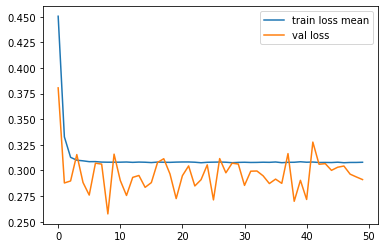

In [45]:
#plt.axis([0, 3000, 0, 200])
plt.plot(history_train, label='train loss mean')
plt.plot(history_val, label='val loss')
plt.legend()
plt.show()

In [46]:
model.eval()
y_val_test = model(t_x_val)
y_val_test = y_val_test.squeeze().cpu().detach().numpy()

In [47]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.2842752

In [48]:
model.eval()
y_pred_test = model(t_x_test)
y_pred_test = y_pred_test.squeeze().cpu().detach().numpy()

In [49]:
y_hat = y_pred_test.squeeze() > optimal_threshold

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print(tn, fp, fn, tp)

247809 32551 1322 16207


In [51]:
tpr = tp / (tp + fn)
tpr

0.9245821210565349

In [52]:
tnr = tn / (tn + fp)
tnr

0.8838957055214723